In [1]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình
import tensorflow as tf
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau, shapiro

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense, Input #đầu ra


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [185]:
# đọc dữ liệu từ file exel
dataset = pd.read_excel('/content/gdrive/MyDrive/dataset.xlsx', sheet_name='ADD')
print(dataset)

        YYYY    MM    DD   TIME             STAMP   Nhiệt độ     Độ mặn  \
0        NaN   NaN   NaN    NaN               NaN        NaN        NaN   
1     2019.0   2.0   5.0  06:00  05/02/2019 06:00  18.000000  33.000000   
2     2019.0   2.0   5.0  09:00  05/02/2019 09:00  18.500000  35.000000   
3     2019.0   2.0   5.0  12:00  05/02/2019 12:00  19.000000  34.000000   
4     2019.0   2.0   5.0  15:00  05/02/2019 15:00  19.537500  33.937500   
...      ...   ...   ...    ...               ...        ...        ...   
1883  2019.0  12.0  15.0  18:00  15/12/2019 18:00  23.281250  34.937500   
1884  2019.0  12.0  16.0  00:00  16/12/2019 00:00  23.140625  34.968750   
1885  2019.0  12.0  16.0  06:00  16/12/2019 06:00  23.320312  34.984375   
1886  2019.0  12.0  16.0  09:00  16/12/2019 09:00  23.000000  35.000000   
1887  2019.0  12.0  16.0  12:00  16/12/2019 12:00  23.500000  35.000000   

           PH       NH3       H2S        TSS       DO       COD Ghi chú  \
0         NaN       NaN 

In [186]:
required_cols = ['STAMP', 'Nhiệt độ', 'Độ mặn', 'PH']
df = dataset[required_cols]
df.head()

df.index = pd.to_datetime(df.STAMP, format='%d/%m/%Y %H:%M')


In [187]:
df = df.fillna(method='ffill')
print(df)

                                STAMP   Nhiệt độ     Độ mặn       PH
STAMP                                                               
NaT                               NaN        NaN        NaN      NaN
2019-02-05 06:00:00  05/02/2019 06:00  18.000000  33.000000  8.25000
2019-02-05 09:00:00  05/02/2019 09:00  18.500000  35.000000  8.20000
2019-02-05 12:00:00  05/02/2019 12:00  19.000000  34.000000  7.90000
2019-02-05 15:00:00  05/02/2019 15:00  19.537500  33.937500  7.91250
...                               ...        ...        ...      ...
2019-12-15 18:00:00  15/12/2019 18:00  23.281250  34.937500  8.02500
2019-12-16 00:00:00  16/12/2019 00:00  23.140625  34.968750  8.01250
2019-12-16 06:00:00  16/12/2019 06:00  23.320312  34.984375  8.05625
2019-12-16 09:00:00  16/12/2019 09:00  23.000000  35.000000  8.00000
2019-12-16 12:00:00  16/12/2019 12:00  23.500000  35.000000  8.10000

[1888 rows x 4 columns]


<ipython-input-187-bd1449118e58>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [188]:
for col in ['Nhiệt độ', 'Độ mặn', 'PH']:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, handle errors

# Perform resampling and calculate mean for numeric columns only
df_final = df[['Nhiệt độ', 'Độ mặn', 'PH']].resample('D').mean()

# If you need 'STAMP' in the final DataFrame:
df_final['STAMP'] = df_final.index.strftime('%d/%m/%Y') # Convert datetime index back to date string
df_final.head()

,Nhiệt độ,Độ mặn,PH,STAMP
STAMP,,,,
2019-02-05,18.821250,34.162500,8.092500,05/02/2019
2019-02-06,19.825521,34.458333,8.110417,06/02/2019
2019-02-07,20.942187,34.250000,8.118750,07/02/2019
2019-02-08,22.058854,34.041667,8.127083,08/02/2019
2019-02-09,23.359896,33.802083,8.137500,09/02/2019


In [189]:
scaler = MinMaxScaler()
numerical_cols = ['Nhiệt độ', 'Độ mặn', 'PH']
data_scaled = scaler.fit_transform(df_final[numerical_cols])

In [190]:
def create_sequences(data, sequence_length=10):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Tạo dữ liệu đầu vào và đầu ra
sequence_length = 5  # Độ dài chuỗi (bạn có thể điều chỉnh)
X, y = create_sequences(data_scaled, sequence_length)

In [191]:
X.shape, y.shape

((310, 5, 3), (310, 3))

In [192]:
# Tính toán số lượng mẫu cho mỗi phần
train_size = int(0.6 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size

# Chia dữ liệu thành train, validation và test
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[:test_size], y[:test_size]

print("Kích thước tập huấn luyện:", X_train.shape)
print("Kích thước tập validation:", X_val.shape)
print("Kích thước tập kiểm tra:", X_test.shape)

Kích thước tập huấn luyện: (186, 5, 3)
Kích thước tập validation: (62, 5, 3)
Kích thước tập kiểm tra: (62, 5, 3)


In [217]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Add a dense output layer
model.add(Dense(3))  # Dự báo 3 giá trị: Temperature, Salinity, pH

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_57 (LSTM)                       │ (None, 5, 128)              │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_58 (LSTM)                       │ (None, 5, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_59 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129,507 (505.89 KB)

 Trainable params: 129,507 (505.89 KB)

 Non-trainable params: 0 (0.00 B)

In [218]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Theo dõi loss của tập kiểm tra
    patience=10,         # Dừng nếu không cải thiện sau 10 epoch
    restore_best_weights=True  # Phục hồi trọng số tốt nhất
)

In [219]:
path = '/content/gdrive/MyDrive/model.keras'
checkpoint = keras.callbacks.ModelCheckpoint(filepath=path, monitor='val_loss', save_best_only=True) # checkpoint callbacks

In [220]:
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - loss: 0.5991 - val_loss: 0.5423
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.4811 - val_loss: 0.3966
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3374 - val_loss: 0.2086
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1659 - val_loss: 0.0467
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0583 - val_loss: 0.0748
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1024 - val_loss: 0.0348
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0599 - val_loss: 0.0112
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0387 - val_loss: 0.0327
Epoch 9/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0508 - val_loss: 0.0381
Epoch 10/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0489 - val_loss: 0.0254
Epoch 11/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0385 - val_loss: 0.0137
Epoch 12/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0301 - val_l

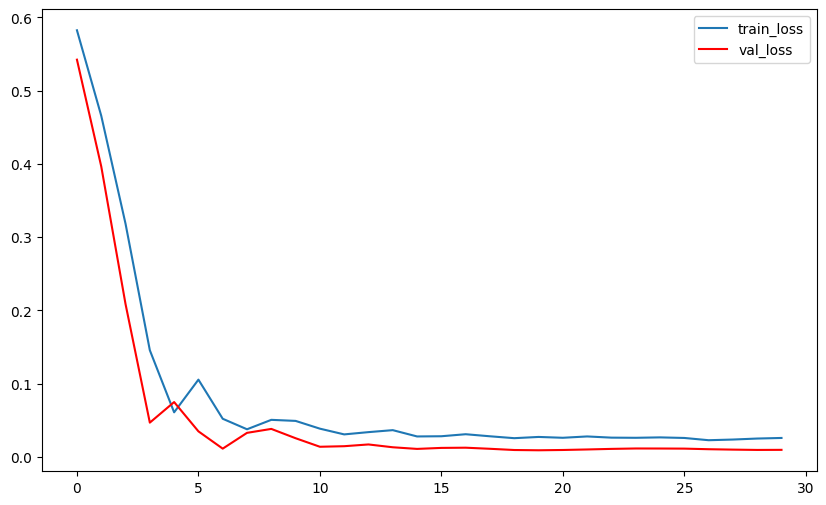

In [221]:
plt.figure(figsize=(10, 6))
plt.plot(model.history.history['loss'], label='train_loss')
plt.plot(model.history.history['val_loss'], c='red', label='val_loss')
plt.legend();

In [222]:
y_pred = model.predict(X_test)

# Chuyển ngược dữ liệu về dạng gốc
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


In [223]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
temp_mae = float(mean_absolute_error(y_test[0], y_pred[0]))# compare with unnoise_dataset
print('Độ lệch trung bình của nhiet do thuc te so với nhiet do du bao là: {:.3f}'.format(temp_mae))
sal_mae = float(mean_absolute_error(y_test[1], y_pred[1]))# compare with unnoise_dataset
print('Độ lệch trung bình của do man thuc te so với do man du bao là: {:.3f}'.format(sal_mae))
pH_mae = float(mean_absolute_error(y_test[2], y_pred[2]))# compare with unnoise_dataset
print('Độ lệch trung bình của pH thuc te so với pH du bao là: {:.3f}'.format(pH_mae))

Độ lệch trung bình của nhiet do thuc te so với nhiet do du bao là: 0.112
Độ lệch trung bình của do man thuc te so với do man du bao là: 0.095
Độ lệch trung bình của pH thuc te so với pH du bao là: 0.086


In [224]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


# Tính MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)

MAE: 0.10780725492177812
MSE: 0.021242583453161462
RMSE: 0.1457483566053541
R2: -0.3641460188910189


In [53]:
dates = df_final.index[sequence_length:]
test_dates = dates[:test_size]

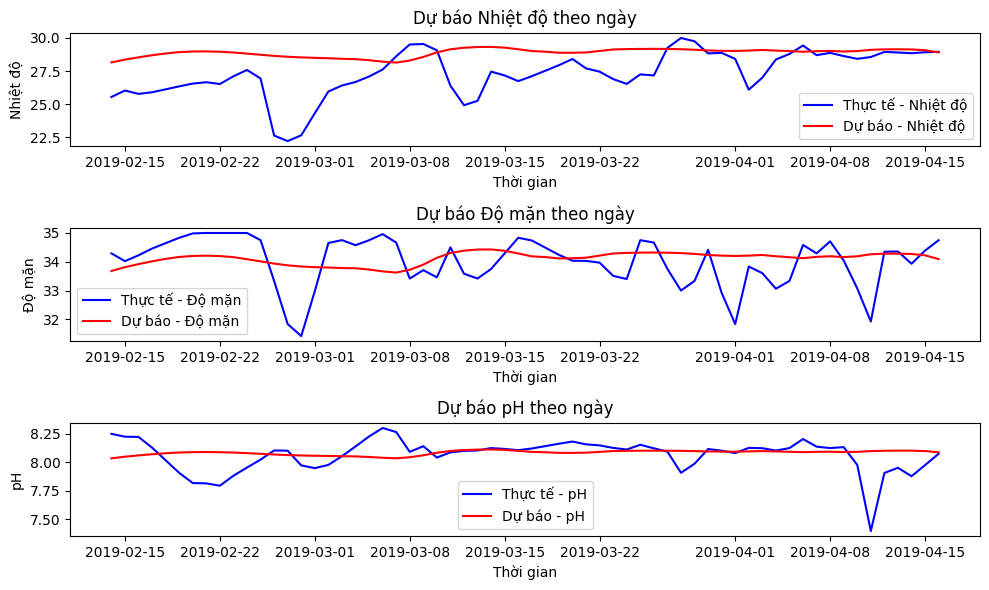

In [54]:
import matplotlib.pyplot as plt

# Vẽ đồ thị cho từng tham số
labels = ['Nhiệt độ', 'Độ mặn', 'pH']

plt.figure(figsize=(10, 6))
for i in range(len(labels)):
    plt.subplot(3, 1, i + 1)
    plt.plot(test_dates, y_test_inverse[:, i], label=f'Thực tế - {labels[i]}', color='blue')
    plt.plot(test_dates, y_pred_inverse[:, i], label=f'Dự báo - {labels[i]}', color='red')
    plt.title(f'Dự báo {labels[i]} theo ngày')
    plt.xlabel('Thời gian')
    plt.ylabel(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()